Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

Описание этапа обработки:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

Краткое описание данных:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

In [1]:
!pip install shap

     |████████████████████████████████| 572 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import shap

In [3]:
try:
    data_arc = pd.read_csv('/Users/admin/Downloads/data_arc_new.csv', 
                           parse_dates = ['Начало нагрева дугой','Конец нагрева дугой'])
    data_bulk = pd.read_csv('/Users/admin/Downloads/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/Users/admin/Downloads/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/Users/admin/Downloads/data_gas_new.csv')
    data_temp = pd.read_csv('/Users/admin/Downloads/data_temp_new.csv', 
                            parse_dates = ['Время замера'])
    data_wire = pd.read_csv('/Users/admin/Downloads/data_wire_new.csv')
    data_wire_time = pd.read_csv('/Users/admin/Downloads/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv', 
                           parse_dates = ['Начало нагрева дугой','Конец нагрева дугой'])
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv', 
                            parse_dates = ['Время замера'])
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

## 1 Рассмотрим каждую из этих таблиц по отдельности

### 1.1 Данные об электродах

In [5]:
data_arc.sample(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
168,37,2019-05-04 16:50:16,2019-05-04 16:53:06,0.465258,0.367007
13274,2889,2019-08-25 02:25:43,2019-08-25 02:33:58,0.760490,0.493423
10798,2346,2019-08-04 20:15:22,2019-08-04 20:16:24,0.625255,0.585101
3817,823,2019-06-04 15:27:23,2019-06-04 15:32:23,0.477902,0.343659
13219,2877,2019-08-24 15:14:44,2019-08-24 15:17:55,0.648005,0.521919


In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


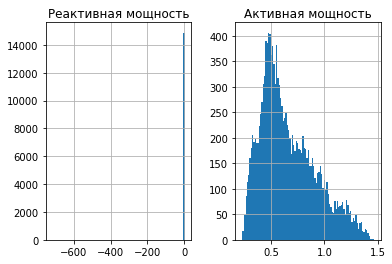

In [7]:
data_arc.hist(column = ['Реактивная мощность', 'Активная мощность'], bins = 100);

In [8]:
data_arc[data_arc['Реактивная мощность'] < 0].count()

key                     1
Начало нагрева дугой    1
Конец нагрева дугой     1
Активная мощность       1
Реактивная мощность     1
dtype: int64

Видимо, отрицательное значение реактивной мощности - это ошибочное значение, скорее всего в дальнейшем его будем удалять. Без него диаграмма распределения будет выглядеть так

<AxesSubplot:>

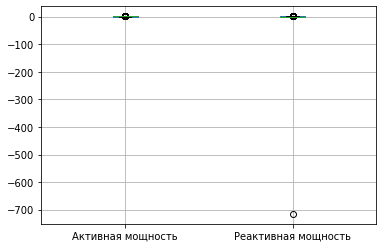

In [9]:
data_arc.drop(columns = 'key').boxplot()

На ящике с усами видим все тот же выброс единичный

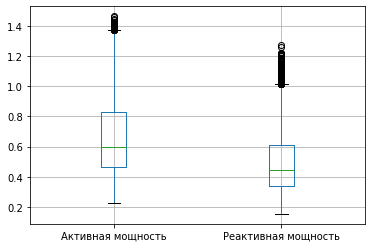

In [10]:
data_arc[data_arc['Реактивная мощность'] > 0].drop(columns = 'key').boxplot();

Теперь видно и другие выбросы. Они не выглядят совсем уж нереальными, планирую оставить

In [11]:
data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропусков нет, отлично

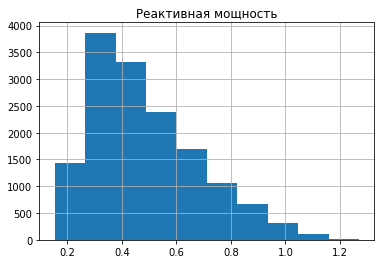

In [12]:
data_arc[data_arc['Реактивная мощность'] > 0].hist(column = ['Реактивная мощность']);

Вот, так гораздо лучше

### 1.3 Данные о подаче сыпучих материалов (объём)

In [13]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Пугающе много нанов. Видимо, здесь указано 15 различных присадок, которые могут быть добавлены в сыпучем виде.

Если какая-то присадка не используется - значит, ее там 0. Можно заменить наны нулями

In [14]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


### 1.4 Данные о подаче сыпучих материалов (время)

In [15]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [16]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


### 1.5 Данные о данные о продувке сплава газом

In [17]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [18]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


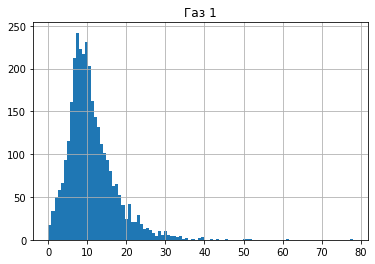

In [19]:
data_gas.hist(column = 'Газ 1',bins = 100);

<AxesSubplot:>

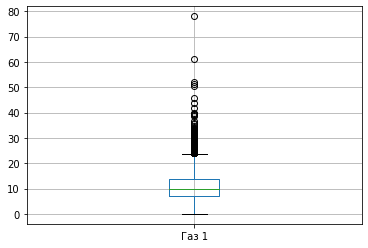

In [20]:
data_gas.boxplot(column = 'Газ 1');

Данные нормально распределены, это всегда приятно видеть. Возможно, нужно будет убрать выбросы больше 50 или больше 60

### 1.6 Результаты измерения температуры

In [21]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Видим, что в этом датафрейме каждому ключу соответствует несколько значений даты и температуры. Температура замеряется каждые 4-5 минут.

In [22]:
data_t= data_temp.Температура

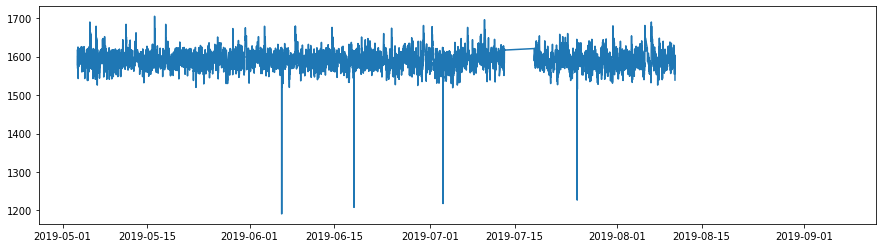

In [23]:
plt.figure(figsize=(15, 4))
plt.plot(data_temp['Время замера'], data_temp['Температура']);

Здесь очень хотелось взять небольшой отрезок этого графика и поставить на нем точки начала нагрева, добавления присадок, продувания газа. И смотреть на поведение температуры. Так сразу не получился график, еще вернусь к этой идее

<AxesSubplot:>

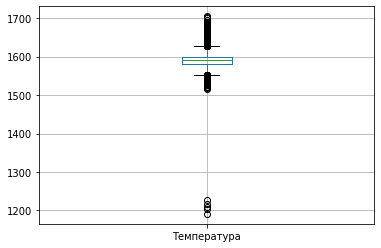

In [24]:
data_temp.boxplot(column = 'Температура');

Видим 4 ярких выброса. А может быть это остужали наш ковш для каких-то целей.
Есть данные с начала мая до середины июля 2019 года, а затем после непонятной константной температуры - еще отрезок, условно с 22 июля до середины августа.

In [25]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [26]:
data_temp.tail(50)

,key,Время замера,Температура
18042,3232,2019-09-06 08:45:13,NaN
18043,3232,2019-09-06 08:51:15,NaN
18044,3232,2019-09-06 08:56:50,NaN
18045,3232,2019-09-06 09:00:52,NaN
18046,3233,2019-09-06 09:15:00,1597.0
18047,3233,2019-09-06 09:21:31,NaN
18048,3233,2019-09-06 09:33:07,NaN
18049,3233,2019-09-06 09:40:13,NaN
18050,3234,2019-09-06 09:41:13,1614.0
18051,3234,2019-09-06 09:47:54,NaN


В конце временного ряда тоже есть значения температуры, но их становится совсем мало. По одному на цикл 

### 1.7 Данные о проволочных материалах (объём)

In [27]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В этом датафрейме видим также некие этапы загрузки проволочных материалов, их 9. Что сразу отметает мечту совместить эту таблицу с таблицей о сыпучих материалах и получить датафрейм без нанов.

In [28]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


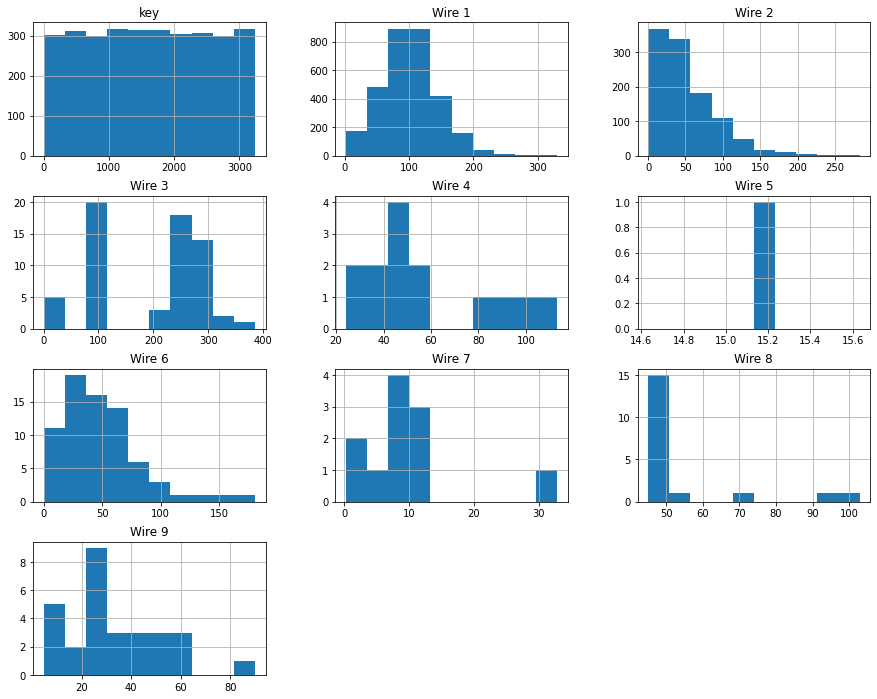

In [29]:
data_wire.hist(figsize = (15,12));

Видим, что не все присадки используются одинаково часто. Нормальное или близкое к нормальному распределение у двух самых часто используемых видов, и еще у wire 6. Остальные диаграммы распределение выгляд странно и непривычно, но это просто техпроцесс, понятна причина такого поведения графиков.

<AxesSubplot:>

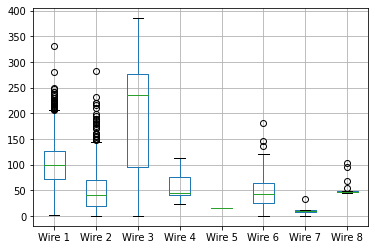

In [30]:
data_wire.boxplot(column = ['Wire 1','Wire 2','Wire 3','Wire 4','Wire 5', 'Wire 6', 'Wire 7', 'Wire 8']);

Выборсы ли это... Скорее, особенности тех процесса. Я бы оставила

### 1.8 Данные о проволочных материалах (время)

In [31]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выводы:
Совсем ярких аномалий не так много, их будем удалять.

В процессе объединения таблиц будет понятно до конца, сколько будет строк для обучения. Т.к не все столбцы всех таблиц важны.

# 2. Подготовка данных
Действовать будем так: брать по очереди имеющиеся таблицы и смотреть, что можно взять в качестве признаков для обучения моделей. То, что нам не понадобится - не будем обрабатывать

Прежде всего избавимся от ковша, в котором такое странное значение реактивной мощности. Уберем данные о нем совсем

In [32]:
a = data_arc[data_arc['Реактивная мощность'] < 0]['key']
a

9780    2116
Name: key, dtype: int64

In [33]:
data_arc = data_arc.query('key != 2116')

In [34]:
data_arc['time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57


Посчитаю для каждой строчки работу. Затем просуммирую работу по каждому ковшу, А = N*t
Буду по совету эксперта использовать значение активная мощность
Также посчитаю медианную общую мощность 

In [35]:
data_arc['agg_capacity'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5

In [36]:
data_arc['A'] = data_arc['Активная мощность']*data_arc['time']
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time,agg_capacity,A
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,128.335684
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157,0.532085,69.038395
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180,0.792429,116.369640
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,1.293389,191.309584
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,0.641792,30.225219


Сложим всю работу для каждого key

In [37]:
data_arc_gr_1 = data_arc.groupby('key').sum(['time', 'A'])
data_arc_gr_1 = data_arc_gr_1[['A', 'time']]


In [38]:
data_arc_gr_2 = data_arc.groupby('key').median()
data_arc_gr_2 = data_arc_gr_2['agg_capacity']

In [39]:
data_arc = data_arc_gr_1.merge(data_arc_gr_2, on = 'key')
data_arc

,A,time,agg_capacity
key,,,
1,628.616930,1098,0.722536
2,395.281800,811,0.650151
3,581.774624,655,0.925082
4,543.710274,741,0.954624
5,412.180480,869,0.639021
...,...,...,...
3237,493.152191,909,0.490253
3238,229.390861,546,0.639539
3239,751.674870,1216,0.690690


Далее посмотрим данные о сыпучих добавках.

Я исхожу из логики, что на температуру влияет масса добавленых ингредиентов. С другой стороны, количество эпизодов добавления тоже может влиять... т.к открывается ковш, температура может снижаться. Если будет плохая метрика - добавлю еще количество.

Время подачи материала учитывать не буду.

Прежде всего заменим наны нулями, чтобы иметь возможность производить арифметические операции с ними

In [40]:
data_bulk = data_bulk.fillna(0)

In [41]:
data_bulk['sum_bulk'] = (data_bulk['Bulk 1'] + data_bulk['Bulk 2']
                         + data_bulk['Bulk 3'] + data_bulk['Bulk 4']
                         + data_bulk['Bulk 5'] + data_bulk['Bulk 6']
                         + data_bulk['Bulk 7'] + data_bulk['Bulk 8']
                         + data_bulk['Bulk 9'] + data_bulk['Bulk 10']
                         + data_bulk['Bulk 11'] + data_bulk['Bulk 12']
                         + data_bulk['Bulk 13'] + data_bulk['Bulk 14']
                         + data_bulk['Bulk 15'])

Данные по газу не нуждаются в дополнительной обработке. Только переименуем столбец.

In [42]:
data_gas.rename(columns = {'Газ 1':'gas'}, inplace = True )


In [43]:
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [44]:
data_gas.duplicated().sum()

0

Далее возьмем данные о добавлении проволки и обработаем их аналогично данным о сыпучих материалах. Заменим наны нулями, просуммируем объем для каждой строки. Время добавления учитывать не будем.

In [46]:
data_wire = data_wire.fillna(0)
data_wire['sum_wire'] = (data_wire['Wire 1'] + data_wire['Wire 2'] 
                         + data_wire['Wire 3'] + data_wire['Wire 4'] 
                         + data_wire['Wire 5'] + data_wire['Wire 6']+ 
                         data_wire['Wire 7'] + data_wire['Wire 8'] + 
                         data_wire['Wire 9'])

Удалим выбросы в таблице температур, а также возьмем только те данные, которые содержат информацию о финальной температуре сплава. Видимо, произошел сбой оборудования и начиная примерно с 10 августа записывались только начальные температуры сплава. Псомтрим эту часть датафрейма поближе, найдем точное время сбоя

In [47]:
data_temp_1 = data_temp[data_temp['Время замера'] > '2019-08-10 12:13:47']
data_temp_1.head(50)

,key,Время замера,Температура
13908,2496,2019-08-10 12:15:29,1584.0
13909,2496,2019-08-10 12:19:09,1580.0
13910,2496,2019-08-10 12:25:13,1591.0
13911,2497,2019-08-10 12:37:26,1571.0
13912,2497,2019-08-10 12:42:22,1577.0
13913,2497,2019-08-10 12:47:44,1576.0
13914,2497,2019-08-10 12:53:28,1589.0
13915,2498,2019-08-10 12:58:11,1591.0
13916,2498,2019-08-10 13:05:03,1570.0
13917,2498,2019-08-10 13:08:23,1580.0


C 14.00 10 августа записывается толко начальная температура сплава. Отрежем этот не информативный "хвост"

In [48]:
data_temp = data_temp[data_temp['Время замера'] < '2019-08-10 14:00:00']

In [49]:
data_temp[data_temp['Температура'] < 1400]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0


Это те выбросы, которые мы видели на графиках. Сохраню эти key в список, потом исключу из итоговой таблицы

In [50]:
list_key = [867, 1214, 1619, 2052]

In [51]:
data_target = data_temp.drop(axis = 1, columns = 'Температура').groupby(['key']).max()


In [52]:
data_target = data_target.query('key not in @list_key')
data_target = data_target.merge(data_temp, on = 'Время замера')
data_target = data_target.rename(columns = {'Время замера':'finish_time', 'Температура':'finish_temp'})
data_target

,finish_time,key,finish_temp
0,2019-05-03 11:30:38,1,1613.0
1,2019-05-03 11:55:09,2,1602.0
2,2019-05-03 12:35:57,3,1599.0
3,2019-05-03 12:59:47,4,1625.0
4,2019-05-03 13:36:39,5,1602.0
...,...,...,...
2468,2019-08-10 11:50:47,2495,1591.0
2469,2019-08-10 12:25:13,2496,1591.0
2470,2019-08-10 12:53:28,2497,1589.0
2471,2019-08-10 13:23:31,2498,1594.0


In [53]:
data_start = data_temp.drop(axis = 1, columns = 'Температура').groupby(['key']).min()

data_start = data_start.merge(data_temp, on = 'Время замера')
data_start = data_start.rename(columns = {'Время замера':'start_time', 'Температура':'start_temp'})
data_start

,start_time,key,start_temp
0,2019-05-03 11:02:04,1,1571.0
1,2019-05-03 11:34:04,2,1581.0
2,2019-05-03 12:06:44,3,1596.0
3,2019-05-03 12:39:27,4,1601.0
4,2019-05-03 13:11:03,5,1576.0
...,...,...,...
2472,2019-08-10 11:27:47,2495,1570.0
2473,2019-08-10 11:56:48,2496,1554.0
2474,2019-08-10 12:37:26,2497,1571.0
2475,2019-08-10 12:58:11,2498,1591.0


In [54]:
data_final = data_target.merge(data_start, on = 'key')
data_final['all_time'] = (data_final['finish_time'] - data_final['start_time']).dt.seconds
data_final = data_final[['key', 'start_temp', 'finish_temp', 'all_time']]


Далее добавляем информацию о работе, суммарном количестве сыпучих веществ, суммарном количестве проволоки и данные о количестве газа.

In [55]:
data_final = data_final.merge(data_arc, on = 'key')
data_final = data_final[['key', 'start_temp', 'time', 'finish_temp', 'agg_capacity', 'A', 'all_time']]
data_final = data_final.merge(data_bulk, on = 'key')
data_final = data_final.merge(data_gas, on = 'key')
data_final = data_final.merge(data_wire, on = 'key')

In [56]:
data_final

,key,start_temp,time,finish_temp,agg_capacity,A,all_time,Bulk 1,Bulk 2,Bulk 3,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,1571.0,1098,1613.0,0.722536,628.616930,1714,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,1581.0,811,1602.0,0.650151,395.281800,1265,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,1596.0,655,1599.0,0.925082,581.774624,1753,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,1601.0,741,1625.0,0.954624,543.710274,1220,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,1576.0,869,1602.0,0.639021,412.180480,1536,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,1570.0,723,1591.0,1.026061,571.539318,1380,0.0,0.0,21.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879
2320,2496,1554.0,940,1591.0,0.647846,675.222467,1705,0.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527
2321,2497,1571.0,569,1589.0,1.531931,680.326674,962,0.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723
2322,2498,1591.0,750,1594.0,0.625538,474.918795,1520,0.0,0.0,90.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717


Итоговая таблица готова.

Сразу построим матрицу корреляции, и можно переходить к следующему этапу.

In [57]:
data_final.corr()

,key,start_temp,time,finish_temp,agg_capacity,A,all_time,Bulk 1,Bulk 2,Bulk 3,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,1.000000,-0.016279,-0.028140,-0.096408,0.004046,-0.019006,-0.019423,-0.078030,-0.006134,-0.006001,...,-0.013408,0.043647,-0.027178,0.049345,NaN,-0.008133,0.037057,-0.035952,0.021416,0.003331
start_temp,-0.016279,1.000000,-0.383939,0.301882,0.002587,-0.345222,0.210786,0.079098,0.141547,-0.113380,...,0.262880,-0.101101,-0.003403,0.076126,NaN,0.020733,0.052812,-0.029831,0.002639,0.131581
time,-0.028140,-0.383939,1.000000,0.277953,0.018675,0.901679,0.562472,0.102708,0.038137,0.091603,...,0.055443,0.054460,0.033251,0.054762,NaN,0.042155,0.027602,0.017781,-0.011746,0.091815
finish_temp,-0.096408,0.301882,0.277953,1.000000,0.026218,0.257862,0.096126,-0.075428,-0.082543,-0.037156,...,0.317488,-0.207242,-0.047636,-0.159839,NaN,-0.084149,-0.137349,-0.010818,-0.027561,0.060496
agg_capacity,0.004046,0.002587,0.018675,0.026218,1.000000,0.331115,0.014438,0.025462,-0.012651,0.011009,...,0.032326,-0.026250,0.020807,-0.013411,NaN,-0.013273,-0.006827,-0.012488,0.005501,0.013965
A,-0.019006,-0.345222,0.901679,0.257862,0.331115,1.000000,0.509485,0.095641,0.038331,0.088805,...,0.060778,0.046604,0.035806,0.048133,NaN,0.047749,0.020018,0.015811,-0.012581,0.092496
all_time,-0.019423,0.210786,0.562472,0.096126,0.014438,0.509485,1.000000,0.144429,0.267480,0.023019,...,0.154280,0.060407,0.068401,0.253402,NaN,0.144125,0.156579,-0.002448,0.006248,0.206743
Bulk 1,-0.078030,0.079098,0.102708,-0.075428,0.025462,0.095641,0.144429,1.000000,0.224677,-0.011538,...,0.013823,-0.009261,0.020204,0.146276,NaN,0.148509,0.083432,-0.019579,0.011013,0.044174
Bulk 2,-0.006134,0.141547,0.038137,-0.082543,-0.012651,0.038331,0.267480,0.224677,1.000000,-0.046953,...,-0.169623,-0.039080,0.223188,0.699339,NaN,0.558882,0.431735,-0.005285,-0.006857,0.090736
Bulk 3,-0.006001,-0.113380,0.091603,-0.037156,0.011009,0.088805,0.023019,-0.011538,-0.046953,1.000000,...,0.037788,0.094897,0.005840,-0.040582,NaN,0.007174,-0.019475,0.004885,0.004668,0.077006


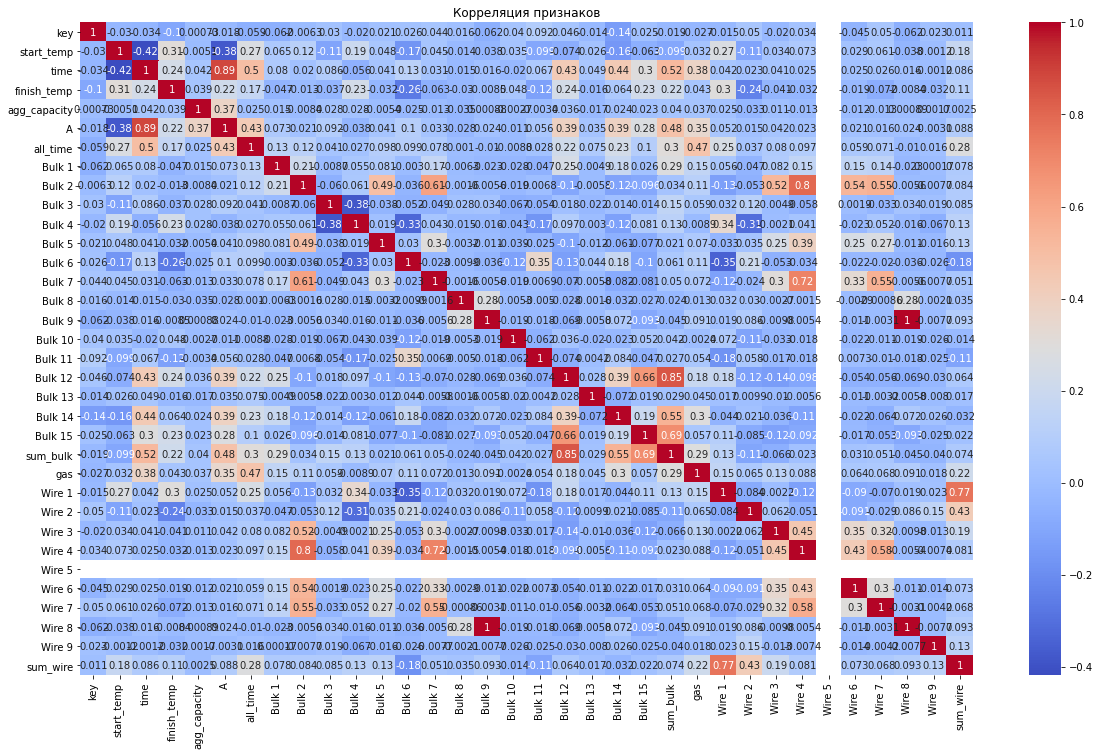

In [58]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(data_final.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [59]:
data_final = data_final.drop(['Wire 5', 'A', 'Wire 8'], axis = 1)

# 3. Обучение моделей
Прежде всего разделим данные на обучающую и тестовую выборки

In [60]:
target = data_final['finish_temp']
features = data_final.drop(['finish_temp', 'key'], axis = 1)

In [61]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=80523)

Стандартизация признаков 

In [62]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Линейная регрессия

In [63]:
lr = LinearRegression()
lr.fit(features_train, target_train)
mean_absolute_error(target_train, lr.predict(features_train))

5.834891805059103

Случайный лес

In [64]:
random_forest = RandomForestRegressor(random_state=80523)

random_forest_params = {
    'n_estimators': range(1, 51, 10),
    'max_depth': range(1,8),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5)
}

grid_forest = GridSearchCV(random_forest,
                             param_grid=random_forest_params,
                             cv=4,
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1)
grid_forest.fit(features_train, target_train)

print('MAE для случайного леса:', mean_absolute_error(target_train,
                                                      grid_forest.predict(features_train)))

MAE для случайного леса: 4.75088708564182


In [65]:
forest = grid_forest.best_estimator_

CatBoost

In [66]:
model_CBR = CatBoostRegressor(random_state=80523, verbose=1)
param_CBR = {'depth' : [3, 4, 5], 'learning_rate' : [0.01, 0.02],
                'iterations' : [321,322, 323], 'verbose' : [False]}
grid_CBR = GridSearchCV(estimator=model_CBR, cv=5, n_jobs=-1,
                        param_grid=param_CBR, scoring = 'neg_root_mean_squared_error')
grid_CBR.fit(features_train, target_train)
best_parameters_CBR = grid_CBR.best_params_
print(best_parameters_CBR)

{'depth': 5, 'iterations': 323, 'learning_rate': 0.02, 'verbose': False}


In [67]:
cat = grid_CBR.best_estimator_

In [68]:
mean_absolute_error(target_train,cat.predict(features_train))

5.509618859320288

## ПРОВЕРКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТЕ

In [69]:
print('MAE на тестовой выборке для случайного леса:', mean_absolute_error(target_test,
                                                                   forest.predict(features_test)))

MAE на тестовой выборке для случайного леса: 6.314270371206155


Построим график значимости признаков для лучшей модели.

In [70]:
features_name = data_final.columns
features_name = features_name.drop(['key', 'finish_temp'])
features_name

Index(['start_temp', 'time', 'agg_capacity', 'all_time', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15',
       'sum_bulk', 'gas', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6',
       'Wire 7', 'Wire 9', 'sum_wire'],
      dtype='object')

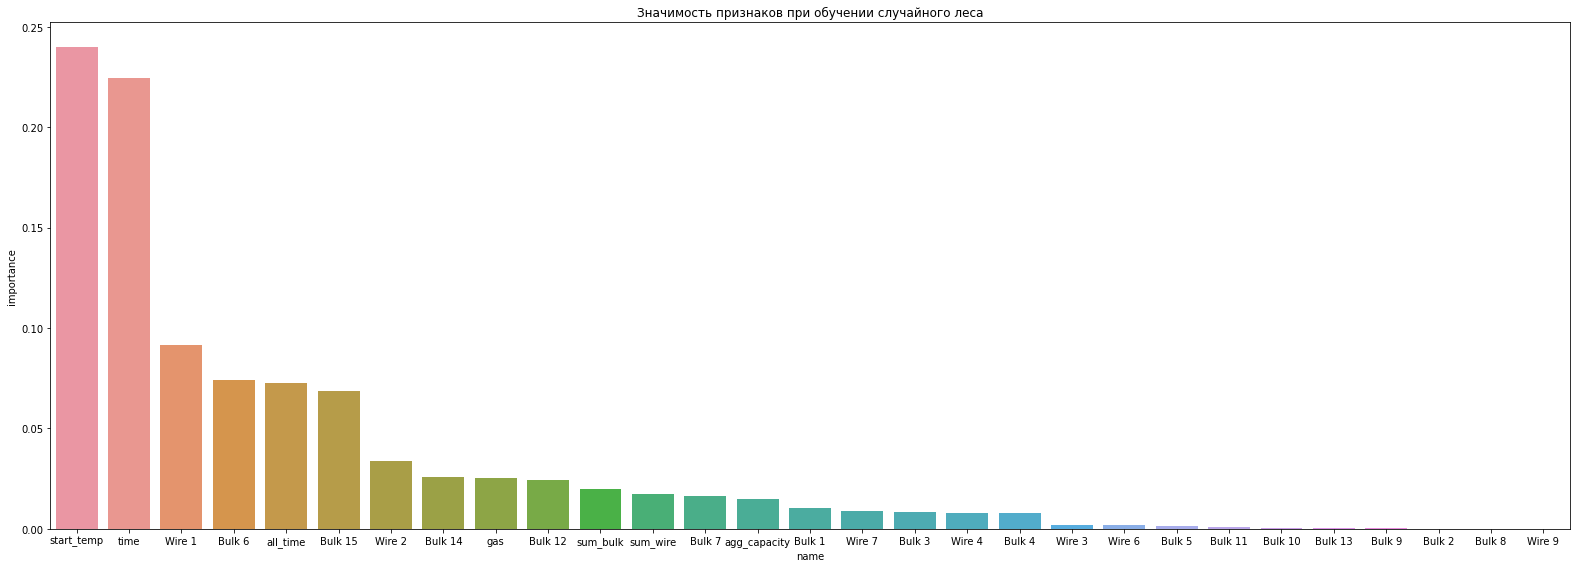

In [71]:
graph = pd.DataFrame( {'name':features_name, 'importance':forest.feature_importances_})
graph = graph.sort_values (by = 'importance', ascending = False)

plt.figure(figsize=(22, 8))
sns.barplot(x="name", y="importance", data=graph)
plt.title('Значимость признаков при обучении случайного леса')
plt.tight_layout()
plt.show();

По графику хорошо видно, что стартовая температура и время нагревания - самые важные признаки при обучении.

Разные присадки имеют очень разное влияние на конечную температуру. От вполне себе ощутимой (3-4-5 места) до нулевой. Было бы очень интересно узнать, с чем это связано. Вероятно это все же термические реакции с поглощением/выделением значительного количества тепла.

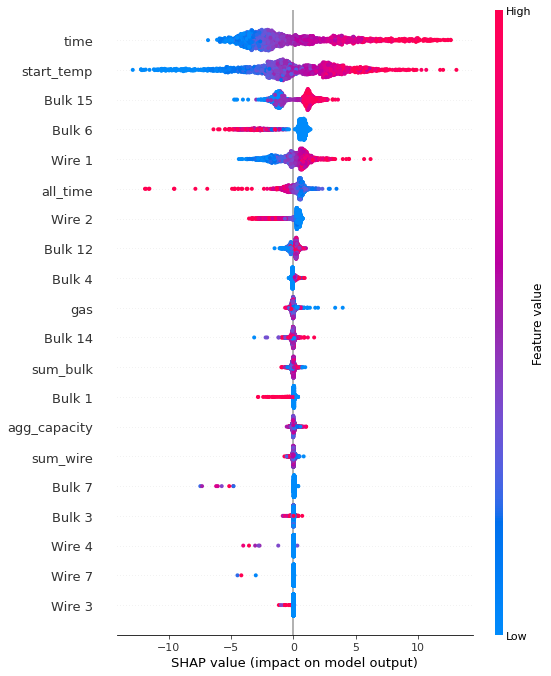

In [72]:
shap_test = shap.TreeExplainer(forest)
shap_values = shap_test.shap_values(features_train)
shap.summary_plot(shap_values, features_train, feature_names = features_name)

Выводы:

Предоставленные данные относительно чистые, имеет место небольшое количество аномальных значений. Данные по температуре предоставлены не за весь период.

Данные очищены и подготовлены.

Признаки для обучения проверены на коллениарность. 

Обучены три модели, выбрана модель с наилучшим значением МАЕ, это  случайный лес.
На тестовой выборке она дает занчение МАЕ = 6,31

Также выполнена визуализация значимости признаков для обучения лучшей модели.

# Отчет
В ходе выполнения проекта были выполнены все пункты плана, с некоторыми поправками:

Выбросов было удалено совсем немного, только те, которые противоречат здравому смыслу. Много данных, которые с математитческой точки зрения являются аномалиями - могут быть частью техпроцесса.

Суммарный объем присадок оказался не очень полезным для обучения признаком. Помимо внесенных в план признаков потребовались и другие - почти все присадки по отдельности,время нагрева, общее время ковша. Мощность в результате оказалась лишним признаком для обучения, время нагрева работало лучше.

При обучении нескольких моделей было принято решение отказаться от обучения дамми модели - ведь было получено очень конкретное целевое значение МАЕ, и нет большого смысла сравнивать дополнительно с дамми.

В ходе проекта возникла трудность с достижением целевого значения МАЕ. Проблема была решена добавлением дополнительных признаков для обучения.

Ключевые шаги выполнения проекта - 

1 Анализ данных

2 Предобработка данных

3 Обучение моделей

4 Работа над уменьшением МАЕ

5 Проверка важности признаков

Итоговая модель - RandomForest, со значением МАЕ на тестовой выборке 6,31.

Признаки, которые были использованы для обучения модели: стартовая температура ковша, время нагрева, медианная общая мощность нагрева, общее время варки, сумма сыпучих присадок, сумма присадок в виде проволки, данные о присадках по отдельности (за исключением 3 малоинформативных).

Параметры лучшей модели:

random_state = 80523, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 41

Для улучшения результатов работы модели необходимо больше информации для обучения - информации о других циклах. Мы обучали модель на 1743 ковшах, а это маловато.

Также необходимо узнать, оставленные нами "выбросы" - реальны, или все же это сбои оборудования. Если  это сбои, то можно их удалить и результаты модели будут лучше.

